In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from IPython.display import display
import os
import random
import shutil
import sys
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [2]:
SCRIPT_PATH = "/content/drive/MyDrive/Video Processing/Hw2/CNN.ipynb"
DATA_DIR = "/content/drive/MyDrive/Video Processing/Hw2/data"
VAL_PATH = "/content/drive/MyDrive/Video Processing/Hw2/data/val"
TRAIN_PATH = "/content/drive/MyDrive/Video Processing/Hw2/data/train"
TRAIN_FULL_PATH = "/content/drive/MyDrive/Video Processing/Hw2/data/train_full"
TEST_PATH = "/content/drive/MyDrive/Video Processing/Hw2/data/test"
LABEL_PATH = "/content/drive/MyDrive/Video Processing/Hw2/trainLabels.csv"

In [3]:
labels = pd.read_csv(LABEL_PATH)

In [4]:
labels["png"] = labels["id"].apply(lambda x: str(x)+".png")

In [5]:
label_nonint = labels['label']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(label_nonint)
labels['intlabel'] = integer_labels

In [6]:
labels

,id,label,png,intlabel
0,1,frog,1.png,6
1,2,truck,2.png,9
2,3,truck,3.png,9
3,4,deer,4.png,4
4,5,automobile,5.png,1
...,...,...,...,...
49995,49996,bird,49996.png,2
49996,49997,frog,49997.png,6
49997,49998,truck,49998.png,9
49998,49999,automobile,49999.png,1


In [38]:
from torchvision.datasets.utils import download_url
import tarfile

In [43]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100%|██████████| 135107811/135107811 [00:03<00:00, 37940104.82it/s]


In [44]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [40]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['cat', 'airplane', 'truck', 'horse', 'automobile', 'bird', 'deer', 'ship', 'frog', 'dog']


In [45]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['4735.png', '1593.png', '4580.png', '2550.png', '1412.png']


In [7]:
class CNNDataset(Dataset):
    def __init__(self, label_df, data_dir, transform=None):
        self.df = label_df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join( self.data_dir, str(self.df.iloc[idx, 0])+".png")
        image = Image.open(img_name)
        label = self.df.iloc[idx, 1]
        intlabel = self.df.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        return image, intlabel

In [18]:
img, intlabel = dataset.__getitem__(0) # dataset objemiz ok gibi görünüyor.

In [21]:
def show_example(img, intlabel):
    print("("+str(intlabel)+")")
    plt.imshow(img.permute(1, 2, 0)) #rgb

(6)


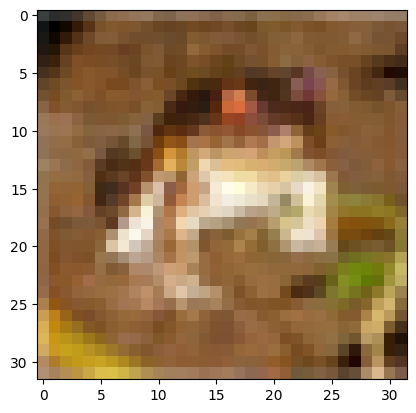

In [22]:
show_example(*dataset[0]) # dünyanın en net kurbağası.

(8)


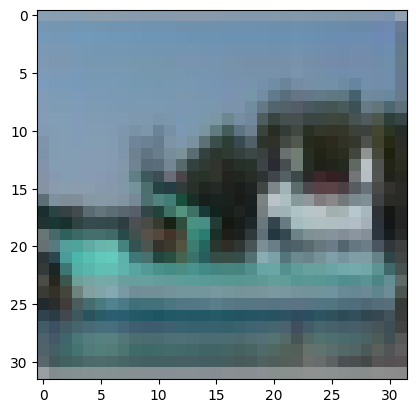

In [23]:
show_example(*dataset[111])

## Test - Train - Validation Datasets

In [24]:
set_len = dataset.__len__() # dataasette toplam 50k gözlem var. yüzde 20 si validation 80 i test olarak ayrılacak.

In [25]:
set_len

50000

In [26]:
# 80 - 20 ayrımını pytorch.utilsten random_split fonksiyonu ile yapıyoruz.
val_len = set_len * 0.2
train_len = set_len - val_len

train_dataset, val_dataset = random_split(dataset, [int(train_len), int(val_len)])
len(train_dataset), len(val_dataset)

(40000, 10000)

In [27]:
# datasetler hazırlandıktan sonra sıradaki adım bir validation ve train setleri için bir DataLoader objesi oluşturmak.
# Dataloader objesi pytorch utilslerinden birisi, forward propagation ve back propagation esnasında verinin batchler halinde
# beslenmesine olanak tanır.

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

In [28]:
from torchvision.utils import make_grid

# bir batch içerisinde hangi görseller veriliyor. bunu görselleştirmek için aşağıdaki fonksiyonu kullanıyoruz.

def show_batch(dl):
    for images, intlabels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=32).permute(1, 2, 0))
        break

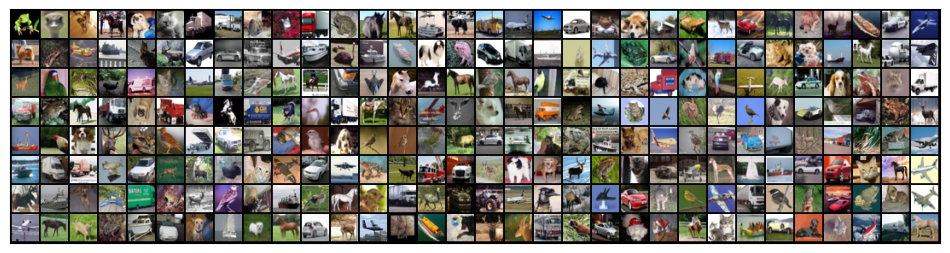

In [29]:
show_batch(train_loader)

## Convolutional Neural Network Class'ının Tanımlanması

In [30]:
# bu simple model kullanılarak her bir convolution'dan çıkacak
# görsellerin sizelarını hesaplamaya gerek kalmadan görebiliriz.

simple_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)
)

In [31]:
for images, intlabel in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 64, 16, 16])


**OUTPUTLARIN DIMENSINLARINI HESAPLAMAK İCİN KULLACAGIMIZ FORMUL**


you can use this formula [(W−K+2P)/S]+1.

W is the input volume - in your case 128

K is the Kernel size - in your case 5

P is the padding - in your case 0 i believe

S is the stride - which you have not provided.

So, we input into the formula:

Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)

40 Filtre Count

In [ ]:
import torch.nn as nn

class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        # Conv layerları tanımlıyoruz.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        # activation function
        self.relu = nn.ReLU()
        # maxpool layer
        self.maxpool = nn.MaxPool2d(2)
        # Overfittingi engellemek için bir dropout
        self.dropout = nn.Dropout(p=0.5)  # dropout probability is 0.5 (you can adjust this value)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(576, 1024) # buradaki input-output doğru mu kontrol edilecek.
        # Burada bir Relu daha olacak
        self.linear2 = nn.Linear(1024, 512)
        # Burada bir Relu Daha olacak.
        self.linear3 = nn.Linear(512, 10)

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv1(x)
        # print("conv1:" , x.shape)
        x = self.relu(x)
        # print("relu:" , x.shape)
        x = self.maxpool(x)
        # print("maxpool:" , x.shape)
        # x = self.conv2(x)
        # print("conv2:" , x.shape)
        x = self.relu(x)
        # print("relu:" , x.shape)
        x = self.maxpool(x)
        print("maxpool:" , x.shape)
        x = self.conv3(x)
        print("conv3:" , x.shape)
        x = self.relu(x)
        print("relu:" , x.shape)
        x = self.maxpool(x)
        print("maxpool:" , x.shape)
        x = self.flatten(x)
        print("flatten:" , x.shape)
        x = self.linear1(x)
        print("linear1:" , x.shape)
        x = self.relu(x)
        print("relu:" , x.shape)
        x = self.dropout(x)  # Dropout overfittin için silver bullet değil, bir çok methodla birlikte çok daha etkili.
        print("dropout:" , x.shape)
        x = self.linear2(x)
        print("linear2:" , x.shape)
        x = self.relu(x)
        print("relu:" , x.shape)
        x = self.dropout(x)
        print("dropout:" , x.shape)
        x = self.linear3(x)

        return x

In [ ]:
ThreeLayerCNNModel = ThreeLayerCNN()

In [ ]:
# bu obje aslında train süreci için önden oluşturulmuştur.
criterion = nn.CrossEntropyLoss()

In [ ]:
for images, intlabel in train_loader:
    print('images.shape:', images.shape)
    out = ThreeLayerCNNModel(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

# sadece bir resim gönderildiğin sağlıklı bir şekilde çıktı alabildiğimizi görmüş olduk.

images.shape: torch.Size([256, 3, 32, 32])
maxpool: torch.Size([256, 64, 8, 8])
conv3: torch.Size([256, 64, 6, 6])
relu: torch.Size([256, 64, 6, 6])
maxpool: torch.Size([256, 64, 3, 3])
flatten: torch.Size([256, 576])
linear1: torch.Size([256, 1024])
relu: torch.Size([256, 1024])
dropout: torch.Size([256, 1024])
linear2: torch.Size([256, 512])
relu: torch.Size([256, 512])
dropout: torch.Size([256, 512])
out.shape: torch.Size([256, 10])
out[0]: tensor([ 0.0208, -0.0555, -0.0042,  0.0403, -0.0618,  0.0988, -0.0216, -0.0317,
         0.0503, -0.0502], grad_fn=<SelectBackward0>)


In [ ]:
def train_model(model, batch):
    print("training_model ..")
    images, intlabel = batch
    outputs = model(images)
    loss = criterion(outputs, intlabel)
    print(type(loss))
    return outputs, loss

In [ ]:
def validation_model(model, val_batch):
    images, intlabel = val_batch
    print("validation model ..")
    outputs = model(images)
    loss = criterion(outputs, intlabel)
    acc = accuracy(outputs, intlabel)
    return (loss.detach(), acc)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  print("evaluating ..")
  outputs = [validation_model(model, val_batch) for val_batch in val_loader]
  batch_losses = [x[0] for x in outputs] # batch losslar
  batch_accs = [x[1] for x in outputs] # her batchin accucarsinin tutulduğu bir liste
  epoch_loss = torch.stack(batch_losses).mean()  # Combine losses # buraya bir .item() lazım
  epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
  return [epoch_loss, epoch_acc]

In [ ]:
tensor1 = torch.tensor([1, 2, 3, 4, 5])
tensor_float = tensor1.float()
tensor2 = torch.tensor([6, 7, 8, 9, 10])
tensor_float2 = tensor2.float()
a = torch.stack([tensor_float, tensor_float2]) ## stack fonksiyonu nasıl çalışıyor.

In [ ]:
history = []
optimizer = optim.Adam(ThreeLayerCNNModel.parameters(), lr= 0.01)

for i in range(10000): # epoch_range
    ThreeLayerCNNModel.train()
    train_losses = []
    for batch in train_loader:
      outputs, loss = train_model(ThreeLayerCNNModel, batch) # training üzerinden loss hesaplanır
      train_losses.append(loss)
      print(outputs, loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(ThreeLayerCNNModel, val_loader)
    result.insert(loss,0) # listesnin bu halinde 0. index train_loss, 1.index validation_loss, 2.index epoch_loss
    history.append(result)
    print(" Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            i, result['train_loss'], result['val_loss'], result['val_acc']))

## Move Models and Tensors Into GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(ThreeLayerCNNModel, device);

In [ ]:
model = to_device(ThreeLayerCNN(), device) # base model performansı

In [ ]:
evaluate(model, val_loader)

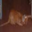

In [ ]:
image = Image.open(TRAIN_PATH + '/3844.png')
display(image)

In [ ]:
image.size

(32, 32)

In [ ]:
import torch.nn as nn

class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        # Define the activation function
        self.relu = nn.ReLU()
        # Define the dropout layers
        self.dropout = nn.Dropout(p=0.5)  # dropout probability is 0.5 (you can adjust this value)

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout after the first convolutional layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout after the second convolutional layer
        x = self.conv3(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout after the third convolutional layer
        return x

In [ ]:
model = ThreeLayerCNN()

In [ ]:
for param in model.parameters():
  print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 5, 5])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 5, 5])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])


In [ ]:
labels = pd.read_csv(LABEL_PATH)

In [ ]:
label_nonint = labels['label']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(label_nonint)
labels['intlabel'] = integer_labels

In [ ]:
labels

In [ ]:
encoded_labels = pd.get_dummies(labels["label"])

In [ ]:
encoded_labels_tensor = torch.tensor(encoded_labels.values)

In [ ]:
labels

In [ ]:
img_name = os.path.join(TRAIN_PATH, str(labels.iloc[0, 0])+".png")

In [ ]:
image = Image.open('/content/drive/MyDrive/Video Processing/Hw2/data/train/27889.png')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Video Processing/Hw2/data/train/27889.png'

In [ ]:
label = labels.iloc[0, 1]

In [ ]:
label

'frog'

In [ ]:
class CNNDataset(Dataset):
    def __init__(self, label_df, root_dir, transform=None):
        self.df = label_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join( self.root_dir, str(self.df.iloc[idx, 0])+".png")
        image = Image.open(img_name)
        label = self.df.iloc[idx, 1]
        intlabel = self.df.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, label, intlabel

In [ ]:
train_dataset = CNNDataset(labels, TRAIN_PATH, transform=transforms.ToTensor())

In [ ]:
train_dataset.__getitem__(0)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
for batch_idx, (data, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print("Data shape:", data.shape)
    print("Targets:", targets)
    # Visualize or further process data if needed
    # Example: print the first image in the batch
    # print(data[0])

    if batch_idx == 0:
        break

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Video Processing/Hw2/data/train/27889.png'

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

In [ ]:
class FiveLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)

    def forward(self, x):
        # Define the forward pass
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x
